# Train WaveNet

In [1]:
from wavenet_model import WaveNetModel
from wavenet_training import AudioFileLoader, WaveNetOptimizer

import torch
import numpy as np
import time

from IPython.display import Audio
from matplotlib import pyplot as plt
from matplotlib import pylab as pl
from IPython import display

%matplotlib notebook

## Setup Model

In [2]:
train_samples = ["train_samples/bach_cello.mp3"]
sampling_rate = 11025
init_model = None

layers = 10
blocks = 3
classes = 256
dilation_channels = 32
residual_channels = 32
skip_channels = 64
kernel_size = 2
dtype = torch.FloatTensor
ltype = torch.LongTensor

use_cuda = torch.cuda.is_available()
if use_cuda:
    dtype = torch.cuda.FloatTensor
    ltype = torch.cuda.LongTensor

In [3]:
model = WaveNetModel(layers=layers,
                     blocks=blocks,
                     dilation_channels=dilation_channels,
                     residual_channels=residual_channels,
                     skip_channels=skip_channels,
                     classes=classes,
                     kernel_size=kernel_size,
                     dtype=dtype)

if use_cuda:
    model.cuda()
    print("use cuda")

#print("model: ", model)
print("receptive_field: ", model.receptive_field)
print("parameter count: ", model.parameter_count())

if init_model != None:
    if use_cuda:
        model.load_state_dict(torch.load(init_model))
    else:
        # move to cpu
        model.load_state_dict(torch.load(init_model, map_location=lambda storage, loc: storage))

data_loader = AudioFileLoader(train_samples,
                              classes=classes,
                              receptive_field=model.receptive_field,
                              target_length=model.output_length,
                              dtype=dtype,
                              ltype=ltype,
                              sampling_rate=sampling_rate)

receptive_field:  3581
parameter count:  170272
total duration of training data:  1167.8824489795918  s


In [4]:
data_loader.start_new_epoch()
start_data = data_loader.get_wavenet_minibatch([model.receptive_field], 
                                               model.receptive_field,
                                               model.output_length)[0]
start_data = start_data.squeeze()

plt.ion()
plt.plot(start_data[-200:].numpy())
plt.ioff()


 start new epoch
with positions:  [  3.19129705e+02   8.21423764e+02   5.80679274e+02   1.10920605e+00
   5.45013424e+02   3.81544943e+02   8.31826304e+02   1.13052780e+03
   5.00431111e+02   3.23168251e+01   7.99132607e+02   7.91702222e+02
   6.38636281e+02   6.46066666e+02   9.31393469e+02   3.86003174e+02
   4.87056417e+02   4.91514648e+02   6.40122358e+02   1.85382766e+02
   4.21669025e+02   5.31219045e+01   8.53959154e+00   5.55415963e+02
   7.38203446e+02   5.73248889e+02   5.71762811e+02   7.42661678e+02
   4.33557641e+02   9.73003628e+02   1.03648526e+02   4.46932335e+02
   6.31205895e+02   1.49716916e+02   6.57955283e+02   1.14241642e+03
   6.44580589e+02   5.90662129e+01   7.87243991e+02   4.94486802e+02
   8.37770612e+02   2.92380317e+02   9.65573242e+02   6.41608435e+02
   3.08307480e+01   2.55228390e+02   2.78585938e+01   2.71575238e+02
   7.44147755e+02   1.74560541e+01   4.95972880e+02   2.96838548e+02
   7.63466757e+02   5.16358274e+01   1.07257079e+03   2.87922086e+02

AttributeError: 'AudioFileLoader' object has no attribute 'get_wavenet_minibatch'

## Train Model

In [5]:
learning_rate = 0.001
mini_batch_size = 4
report_interval = 4
test_interval = 16
snapshot_interval = 256
epochs = 20
segments_per_chunk=8
examples_per_segment=64
test_segments = 8
examples_per_test_segment = 32
model_path = "model_parameters/bach_10-5-256-32-32-256-2"

In [6]:
def report_callback(losses):
    ax.clear()
    ax.plot(losses)
    fig.canvas.draw()

optimizer = WaveNetOptimizer(model,
                             data=data_loader,
                             test_segments=test_segments,
                             examples_per_test_segment=examples_per_test_segment,
                             report_callback=report_callback,
                             report_interval=report_interval,
                             test_interval=test_interval,
                             snapshot_interval=snapshot_interval,
                             snapshot_file=model_path)


The test set has a total duration of  11.888616780045352  s


<IPython.core.display.Javascript object>


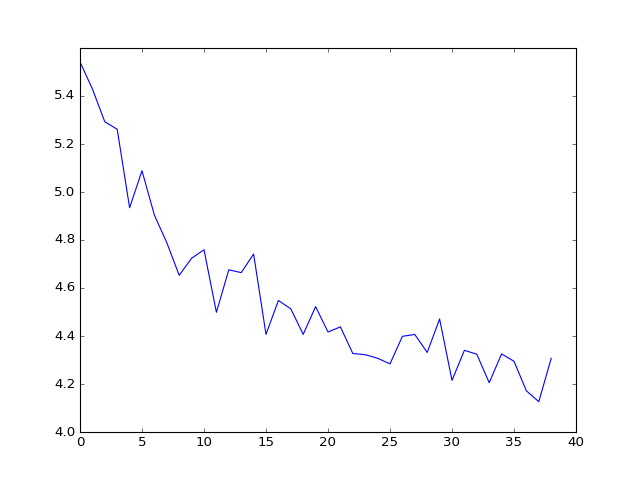

start training...
epoch  0

 start new epoch
with positions:  [  5.47282241e+02   1.03174338e+03   1.63874350e+02   7.58305189e+02
   6.00781017e+02   1.11199154e+03   2.12109488e+01   7.16695030e+02
   1.05254845e+03   4.16507457e+02   1.04065984e+03   4.04618840e+02
   3.01274113e+01   6.27530405e+02   2.73844055e+02   7.49388727e+02
   3.09509906e+02   1.05849276e+03   3.15454214e+02   9.57439520e+02
   6.09697479e+02   6.78057026e+02   9.93105371e+02   9.00968590e+02
   4.25423919e+02   5.39046449e+01   1.93595892e+02   1.28208500e+02
   8.38553352e+02   3.06537751e+02   8.32609044e+02   8.74219203e+02
   7.79110268e+02   4.46228999e+02   7.04806414e+02   1.08524215e+03
   1.10604723e+03   4.05869390e-01   7.34527956e+02   1.40097117e+02
   8.14776119e+02   2.82760518e+02   6.86973488e+02   9.51495212e+02
   5.26477162e+02   1.15360170e+03   1.13279662e+03   7.88026731e+02
   4.61089770e+02   4.19479611e+02   2.17373126e+02   7.47097243e+01
   1.04660415e+03   8.95704952e+01   5.20

KeyboardInterrupt: 

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

print('start training...')
tic = time.time()
optimizer.train(learning_rate=learning_rate,
                minibatch_size=mini_batch_size,
                epochs=epochs,
                segments_per_chunk=segments_per_chunk,
                examples_per_segment=examples_per_segment)
toc = time.time()
print('Training took {} seconds.'.format(toc-tic))

In [ ]:
torch.save(model.state_dict(), model_path)